### Implementation of schemes for the Heat Equation:
- The Forward Time Centered Space Method(Explicit);
- The Backward Time Centered Space Method(Implicit);
- Crank-Nicolson(Implicit);


\begin{equation}
    \partial_{t}u = \partial^2_{x}u , \quad 0 < x < 1, \quad t > 0 \\
\end{equation}
\begin{equation}
    \partial_{x}u(0,t) = 0, \quad \partial_x{u}(1,t) = 0\\
\end{equation}
\begin{equation}
    u(x, 0) = cos(\pi x)
\end{equation}

### Exact Solution: 
\begin{equation}
    u(x,t) = e^{-\pi^2t}cos(\pi x)
\end{equation}

In [1]:
#Numerical Differential Equations 
import math, sys 
import numpy as np
import sympy as sp
from scipy import sparse
from sympy import fourier_series, pi
from scipy.fftpack import *
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

In [2]:
#Heat equation in one dimensional wire within the Explicit Method 
#Heat function exact solution
def Solution(x, t):
    return np.exp((-np.pi**2)*t)*np.cos(np.pi*x)

In [3]:
def surfaceplot(U, Uexact, tspan, xspan, M): 
    N = M**2
    X, T = np.meshgrid(tspan, xspan)
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    
    ax = fig.add_subplot(1, 4, 1,projection='3d')
    surf = ax.plot_surface(X, T, Uexact, linewidth=0, cmap=cm.jet, antialiased=True)
    ax.set_title('Exact Solution')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')
    ax.set_zlabel('U')
    ax1 = fig.add_subplot(1, 4, 2,projection='3d')
    surf = ax1.plot_surface(X, T, U, linewidth=0, cmap=cm.jet, antialiased=True)
    ax1.set_title('Approximation')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Space')
    ax1.set_zlabel('U')
    
    plt.tight_layout()
    ax.view_init(30,230)
    ax1.view_init(30,230)
    
    fig.savefig(path.join("plot_METHOD{0}.png".format(count)),dpi=600)
    plt.draw()
    

In [4]:
def ExactSolution(M, T = 0.5, L = 1):
    N = (M**2) #GRID POINTS on time interval

    xspan = np.linspace(0, L, M)
    tspan = np.linspace(0, T, N)
    
    Uexact = np.zeros((M, N))
    
    for i in range(0, M):
        for j in range(0, N):
            Uexact[i][j] = Solution(xspan[i], tspan[j])
    
    return (Uexact, tspan, xspan)

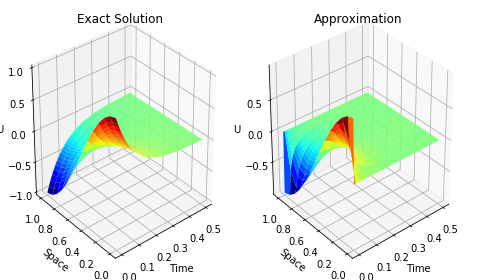

In [5]:
def ForwardEuler(M, lambd, T = 0.5, L = 1, k = 1): 
    N = (M**2) 
    x0, xL = 0, L
    dx = (xL - x0)/(M-1)
    t0,tF = 0, T
    dt = (tF - t0)/(N-1)
    
    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    U = np.zeros((M, N))

    U[:,0] = np.cos(np.pi*xspan)


    
    f = np.arange(1, N+1)
    f = (-3*U[0,:] + 4*U[1,:] - U[2,:])/2*dx
    U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1)
    g = (-3*U[-1,:] + 4*U[-2,:] - U[-3,:])/2*dx
    U[-1,:] = (4*U[-2,:] - U[-3,:])/3
    
    # -----  ftcs -----
    for k in range(0, N-1):
        for i in range(1, M-1):
            U[i, k+1] = lambd*U[i-1, k] + (1-2*lambd)*U[i,k] + lambd*U[i+1,k] 
    
    return (U, tspan, xspan)

U, tspan, xspan = ForwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)

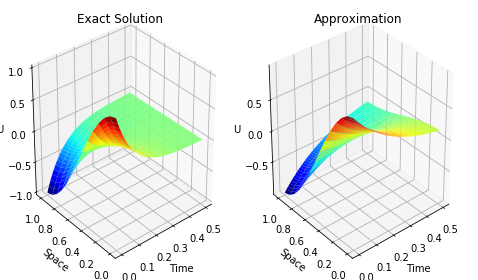

In [6]:
def BackwardEuler(M, lambd, T = 0.5, L = 1, k = 1):
    
    N = (M**2) 

    x0, xL = 0, L 

    dx = (xL - x0)/(M-1)

    t0, tF = 0, T 

    dt = (tF - t0)/(N-1)

    a = 1 + 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    main_diag = (1 + 2*lambd)*np.ones((1,M))
    off_diag = -lambd*np.ones((1, M-1))
    a = main_diag.shape[1]
    diagonals = [main_diag, off_diag, off_diag]

    A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    A[0,1] = -2*lambd
    A[M-1,M-2] = -2*lambd

    U = np.zeros((M, N))
    
    U[:,0] = np.cos(np.pi*xspan)
    
    f = np.arange(1, N+1) 
    f = U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1) 
    g = U[-1,:] = (4*U[-2,:] - U[-3,:])/3

    
    for i in range(1, N):
        c = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([2*lambd*dx*f[i], 2*lambd*dx*g[i]])
        b1 = np.insert(b1, 1, c)
        b2 = np.array(U[0:M, i-1])
        b = b1 + b2  
        U[0:M, i] = np.linalg.solve(A,b)  
    
    return (U, tspan, xspan)

U, tspan, xspan = BackwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)

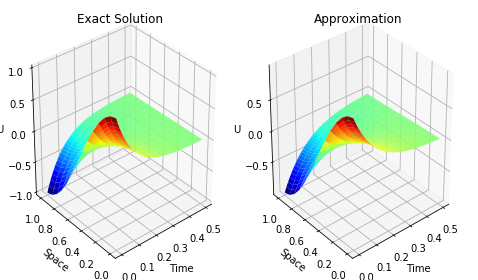

In [7]:
def CrankNicolson(M, lambd, T = 0.5, L = 1, k = 1):

    N = (M**2) 

    x0, xL = 0, L

    dx = (xL - x0)/(M-1)

    t0, tF = 0, T 

    dt = (tF - t0)/(N-1)

    a0 = 1 + 2*lambd
    c0 = 1 - 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    maindiag_a0 = a0*np.ones((1,M))
    offdiag_a0 = (-lambd)*np.ones((1, M-1))

    maindiag_c0 = c0*np.ones((1,M))
    offdiag_c0 = lambd*np.ones((1, M-1))

    a = maindiag_a0.shape[1]
    diagonalsA = [maindiag_a0, offdiag_a0, offdiag_a0]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    
    A[0,1] = (-2)*lambd
    A[M-1,M-2] = (-2)*lambd

    c = maindiag_c0.shape[1]
    diagonalsC = [maindiag_c0, offdiag_c0, offdiag_c0]
    
    Arhs = sparse.diags(diagonalsC, [0,-1,1], shape=(c,c)).toarray()
    Arhs[0,1] = 2*lambd
    Arhs[M-1,M-2] = 2*lambd

    U = np.zeros((M, N))

    U[:,0] = np.cos(np.pi*xspan)


    
    f = np.arange(1, N+1) 
    f = U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1) 
    g = U[-1,:] = (4*U[-2,:] - U[-3,:])/3
    
    for k in range(1, N):
        ins = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([4*lambd*dx*f[k], 4*lambd*dx*g[k]])
        b1 = np.insert(b1, 1, ins)
        b2 = np.matmul(Arhs, np.array(U[0:M, k-1]))
        b = b1 + b2  
        U[0:M, k] = np.linalg.solve(A,b)  
    
    return (U, tspan, xspan)

U, tspan, xspan = CrankNicolson(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)